# 导入库

In [2]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
# 做图形变化的包
import torchvision.transforms as transform
# 数据集分类
from torchvision.datasets import ImageFolder
# 数据处理
from torch.utils.data import DataLoader, Dataset, ConcatDataset
# 通过直接调用torch.nn内的函数，可以避免自己实现许多比如损失函数，从而降低代码复杂度，使代码更加简洁，效率更高
import torch.nn as nn
# 有许多预训练好的模型
import torchvision.models as models
from torchvision.utils import make_grid
# 包含损失函数和激活函数等
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

# matlab作图函数
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

# 基于matlab二次封装的作图库
import seaborn as sns

# 划分训练集和测试集
from sklearn.model_selection import train_test_split

import warnings

# 用于保存模型，方便下次直接调用不用重新训练
import pickle

# 忽略警告信息
warnings.filterwarnings('ignore')

# 使用GPU加速
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 训练数据预处理

### 1. 数据存放路径

In [3]:
path = 'data/flowers'

### 2. 查看数据读取是否正常

### 随机取一张图片，通过直方图可以看到没有经过归一化处理的图片信息非常分散

Shape:  (263, 320, 3)


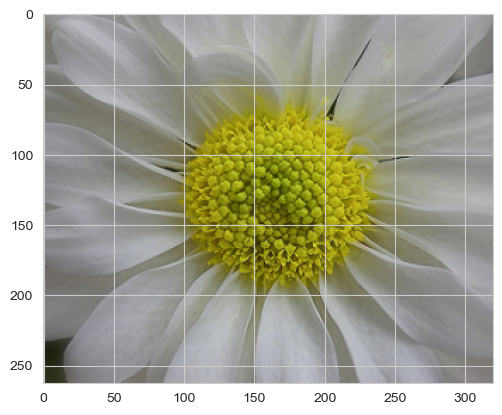

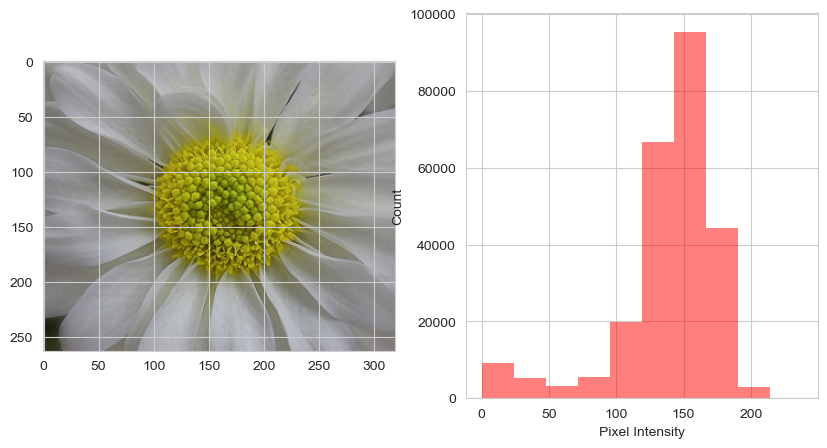

In [4]:
example = path + os.sep + 'daisy'

# mpimg用于读取图片
img_example = mpimg.imread(example + '/100080576_f52e8ee070_n.jpg')
print('Shape: ', img_example.shape)
# plt用于显示图片
plt.imshow(img_example)


def plot_hist(img):
    """
    展示像素分布的强度
    :param img:
    :return:
    """
    # 创建图像，可以理解为创建一个画布
    plt.figure(figsize=(10, 5))
    # 在画布上创建图像，图像内容是plt.imshow(img)里面的参数img
    # 将图像划分为1行2列，当前位置设定为第1行第1个图像
    plt.subplot(1, 2, 1)
    # 展示图象
    plt.imshow(img)
    # 显示坐标轴以及标签
    plt.axis('on')
    # 当前位置设定为第一行第2个图像
    histo = plt.subplot(1, 2, 2)
    # 设置图像x，y轴的标签
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    # 创建直方图
    plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')


plot_hist(img_example)

### 数据准备

**original：是原始数据集
dataset1-3：是对原始数据集作了额外的图片变换以后的增强数据集，它们将会作为原始数据集划分出来的训练集的扩充，同时可有效防止过拟合**

**定义对数据集的处理方式**

In [5]:
# 对图片训练数据做不同的变换处理，生成多个数据集
transformer = {
    # transform.Compose([...])用于将列表内的transform操作合起来一并完成
    'original': transform.Compose([
        transform.Resize((220, 220)),
        # 把PIL.Image或ndarry从(H,W,C)转换为(C,W,H)，H代表图片高度，也就是行，W代表宽度，也就是列，C代表通道数，同时还会归一化数据到[0,1]
        transform.ToTensor(),
        transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178),
                            (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
    ]),
    'dataset1': transform.Compose([
        transform.Resize((220, 220)),
        # 改变图像属性，包括亮度、对比度、饱和度和色调
        transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        # 随即图片旋转，旋转角度在[-5,5]
        transform.RandomRotation(5),
        # 随即仿射变换函数
        transform.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),

        transform.ToTensor(),
        transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178),
                            (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)),
    ]),
    'dataset2': transform.Compose([
        transform.Resize((220, 220)),

        # 依据概率p对PIL图片进行水平翻转，默认为0.5
        transform.RandomHorizontalFlip(),
        transform.RandomRotation(10),
        transform.RandomAffine(translate=(0.05, 0.05), degrees=0),

        transform.ToTensor(),
        # 用随机大小和比例的矩形随机擦除图像
        transform.RandomErasing(inplace=True, scale=(0.01, 0.23)),
        transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178),
                            (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))]),
    'dataset3': transform.Compose([
        transform.Resize((220, 220)),

        transform.RandomHorizontalFlip(p=0.5),
        transform.RandomRotation(15),
        transform.RandomAffine(translate=(0.08, 0.1), degrees=15),

        transform.ToTensor(),
        transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178),
                            (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))])
}

**对数据集做归一化处理，并划分训练集、验证集和测试集**

In [6]:
# bs是batch_size的缩写，表示一次加载50个样本数据
bs = 32

# 这个包是用于读取数据集目录并自动给数据集分类，它的分类逻辑是存放数据的文件夹下有几个子文件夹，就分几类，一个文件夹为一类，该类所有图片都放在这个文件夹下
# 返回一个列表，用元组存放着每个图片的信息，形式为（PIL图片，类别标签索引）
# transform参数的作用就是用来告诉ImageFolder对图片做什么处理
original = ImageFolder(path, transform=transformer['original'])

# all_set = train_val + test
# 对作了transformer['original']变换的图片数据集划分训练集和测试集，测试集占数据集的30%，设置随机数种子为43，保证每次训练都是相同的划分方式，方便调参这样在后面做进一步划分的时候就不会打乱顺序
train_val, test = train_test_split(original, test_size=0.3, shuffle=True, random_state=43)

# train_val = train_val + dataset1 + dataset2 + dataset3
# 拼接数据集，将作了不同变换的图片集合用于拓展训练集
train_val = ConcatDataset([train_val,
                           ImageFolder(path, transform=transformer['dataset1']),
                           ImageFolder(path, transform=transformer['dataset2']),
                           ImageFolder(path, transform=transformer['dataset3'])])

# 划分训练集和验证集
train, val = train_test_split(train_val, test_size=0.2, shuffle=True, random_state=43)

# 数据加载器，设置每一批次的大小为bs，使用gpu的内存，并行读取数据
loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=True),
    'val': DataLoader(val, batch_size=bs, num_workers=4, pin_memory=True),
    'test': DataLoader(test, batch_size=bs, num_workers=4, pin_memory=True)
}

# 数据集大小
dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test),
}

print(dataset_sizes)

{'train': 16803, 'val': 4201, 'test': 1704}


### 对数据集的RGB三个通道做归一化处理

**在训练过程中，未归一化的数据可能会使正则化产生损失，而归一化的目的就是使得平均值尽可能地接近0，同时标准差接近1**

#### 下面是展示图片的3个通道代码

[]

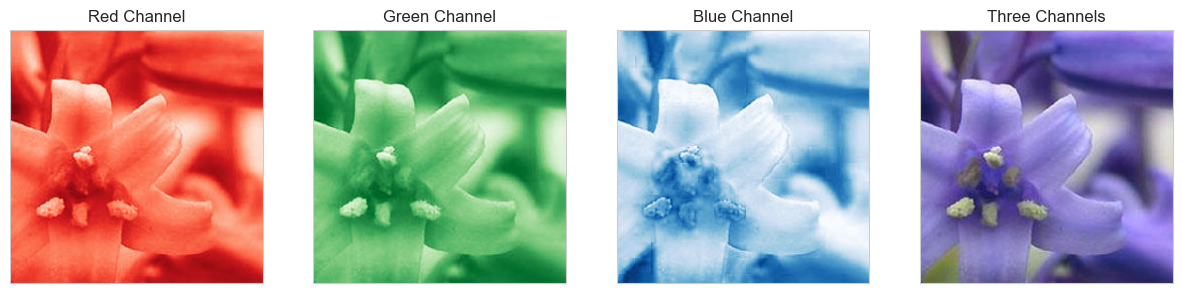

In [7]:
# transform.CenterCrop()是用于中心裁剪的，依据给定的size从中心裁剪，这里是(255,255)
example_set = ImageFolder(path, transform=transform.Compose([transform.ToTensor(), transform.CenterCrop(255), ]))

x, y = next(iter(DataLoader(example_set)))

channels = ['Red', 'Green', 'Blue']
# 设置matplotlib中色表RGB三种颜色，便于后面imshow展示这三个通道的单色图片
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i, :, :], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    # 设置坐标轴刻度为空
    axs.set_xticks([])
    axs.set_yticks([])

# 因为上面作了ToTensor()的操作将(C,H,W)转换回(H,W,C)才能显示
ax[3].imshow(x[0].permute(1, 2, 0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([])

### 对图片数据分别计算train、val、test三个数据集的平均值和标准差

In [9]:
channels = 3

# 分别计算三个通道下数据集的平均值和标准差
for channel in range(channels):
    # 计算三个数据集所有图片的平均值和标准差
    for x in ['train', 'val', 'test']:
        # number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        # 每张图片大小都是220*220，乘上每个数据集中的图片数量
        num_pxl = dataset_sizes[x] * 220 * 220

        # go through the butches and sum up the pixels of the objects,
        # which then divide the sum by the number of all pixels to calculate the average
        # 计算所有像素点数据的平均值
        total_sum = 0
        for batch in loaders[x]:
            # batch是DataLoader('train', ...),而DataLoader的返回值是数据集的图片信息，batch[0]是上面train这个数据集的图片数据，而batch[1]就是这些图片的标签，而且这两个都是tensor类型
            # 取每个batch的第一个图片信息，然后用itemgetter函数，获取该图片所有列表上索引为channel的值并形成新的列表
            # 其实就是，[0,1,2]在三维张量的图片数据中就代表了RGB三个通道的矩阵数据
            # 其实就是分别获取RGB三个通道的图片数据
            # map用于将batch[0]作为参数传递给itemgetter()获取索引为channel的值
            layer = list(map(itemgetter(channel), batch[0]))

            # 可以理解为一个矩阵的拼接函数，而这里就是将layer中所有的tensor类型的张量序列拼接为一个张量
            # 将所有图片同一通道上的数据拼接到一起
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        # calculate the standard deviation using the formula that I indicated above
        # 计算标准差
        sum_sqrt = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)

        print(f'|channel:{channel + 1}| {x} - mean: {mean}, std: {std}')

|channel:1| train - mean: -0.11548435688018799, std: 0.9608626365661621
|channel:1| val - mean: -0.11977437138557434, std: 0.9599577188491821
|channel:1| test - mean: 0.11762487888336182, std: 0.8891754150390625
|channel:2| train - mean: -0.060389626771211624, std: 0.97552889585495
|channel:2| val - mean: -0.0694580227136612, std: 0.9737265706062317
|channel:2| test - mean: 0.17568208277225494, std: 0.8906301259994507
|channel:3| train - mean: -0.04158730432391167, std: 0.9553451538085938
|channel:3| val - mean: -0.050252750515937805, std: 0.9488347172737122
|channel:3| test - mean: 0.12905901670455933, std: 0.9599025845527649


**获取一个batch看下平均值和标准差**

In [8]:
# iter()用于将DataLoader数据加载器里面的数据打包成一个迭代器，而next()就是将其中第一个批次的数据取出来赋值给x，标签赋值给y
x, y = next(iter(loaders['train']))
x.mean(), x.std()

(tensor(-0.1168), tensor(0.9303))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


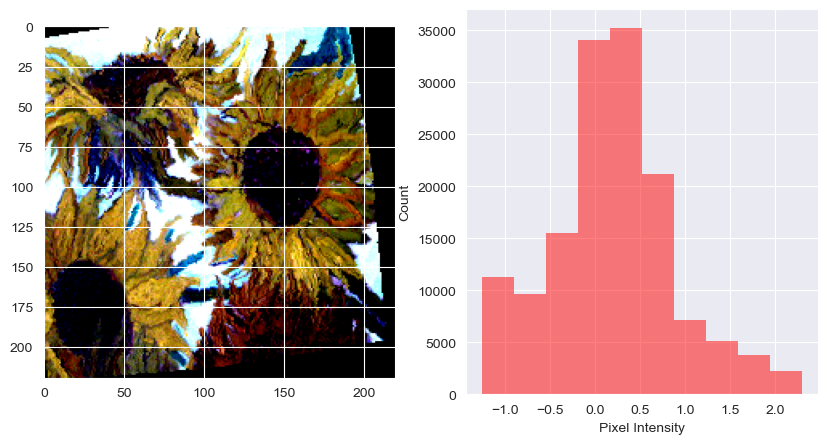

In [9]:
x, y = next(iter(loaders['train']))

# permute()是一个维度转换函数，可以理解为原维度顺序是（0，1，2），而在函数中打乱顺序输入，比如下面
img = x[0].permute(1, 2, 0).numpy()
plot_hist(img)

In [10]:
print('Classes:', original.classes)
print('Number of classes:', len(original.classes))

Classes: ['bluebell', 'buttercup', "colts'foot", 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'rose', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']
Number of classes: 18


### 获取每个类别花朵图片的图片个数，看看各个种类的花的图片数量相差大不大，由结果可以看出，样本数量最多的类别与最少的类别相差大约是47%，因此可以忽略样本数量的差异

### 添加新的样本后出现了较大的样本数据差异，导致解冻训练阶段使模型训练效果反而不好

In [11]:
dic = {}

for classes in original.classes:
    dic[classes] = [
        len([os.path.join(path + '/' + classes, filename) for filename in os.listdir(path + '/' + classes)])]

# 从字典dic中加载数据，key值作为标签，value是具体数据
sample_size = pd.DataFrame.from_dict(dic)
sample_size

bluebell  buttercup  colts'foot  cowslip  crocus  daffodil  daisy  \
0        80         80          80       80      80        80    844   

   dandelion  fritillary  iris  lilyvalley  pansy  rose  snowdrop  sunflower  \
0       1132          80    80          80     80   784        80        813   

   tigerlily  tulip  windflower  
0         80   1064          80

### 画数据集中每个类别包含图片数量的柱形图

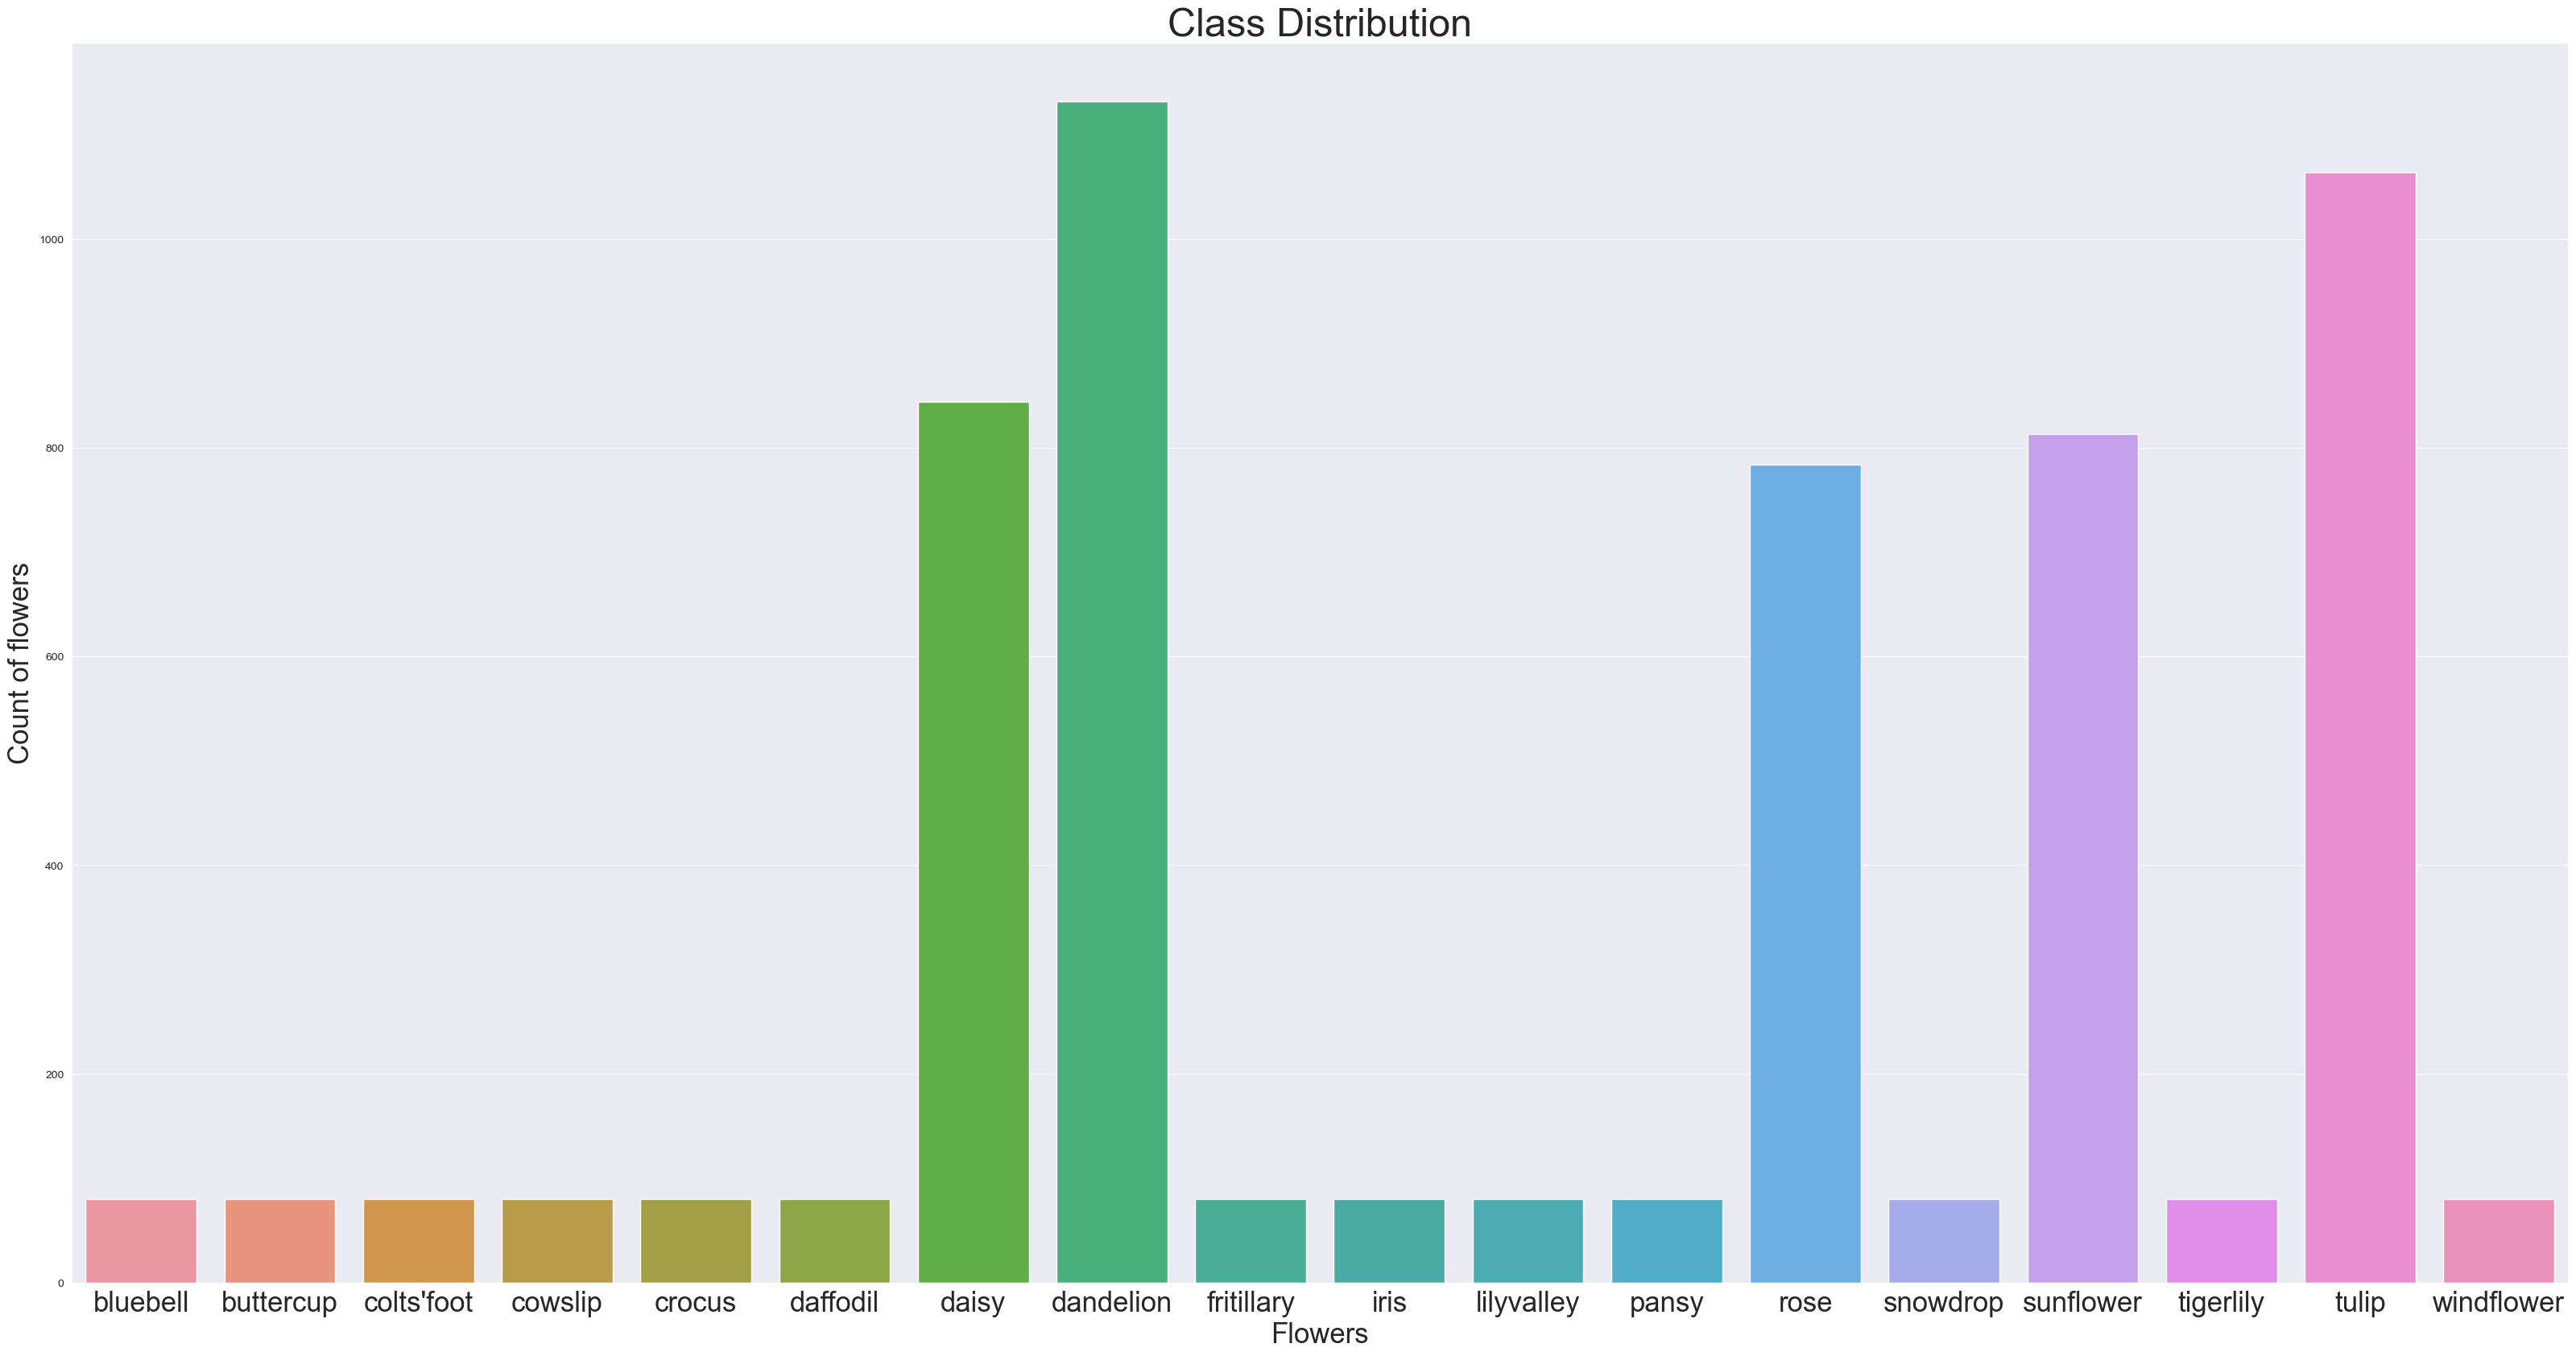

In [12]:
# 图形属性修改函数，也可以称之为图形属性重命名函数
figure_size = plt.rcParams['figure.figsize']
# 设置图形大小
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

# 绘制柱形图
sns.barplot(data=sample_size)

# 设置一个数组类型的值，方便后面设置刻度
index = np.arange(len(original.classes))

plt.xlabel('Flowers', fontsize=25)
plt.ylabel('Count of flowers', fontsize=25)
# 设置刻度以及刻度标签
plt.xticks(index, original.classes, fontsize=25)
plt.title('Class Distribution', fontsize=35)
plt.show()

### 展示未经过增强变换的original图片数据集与经过增强图形变换操作的dataset1-3数据集的差异

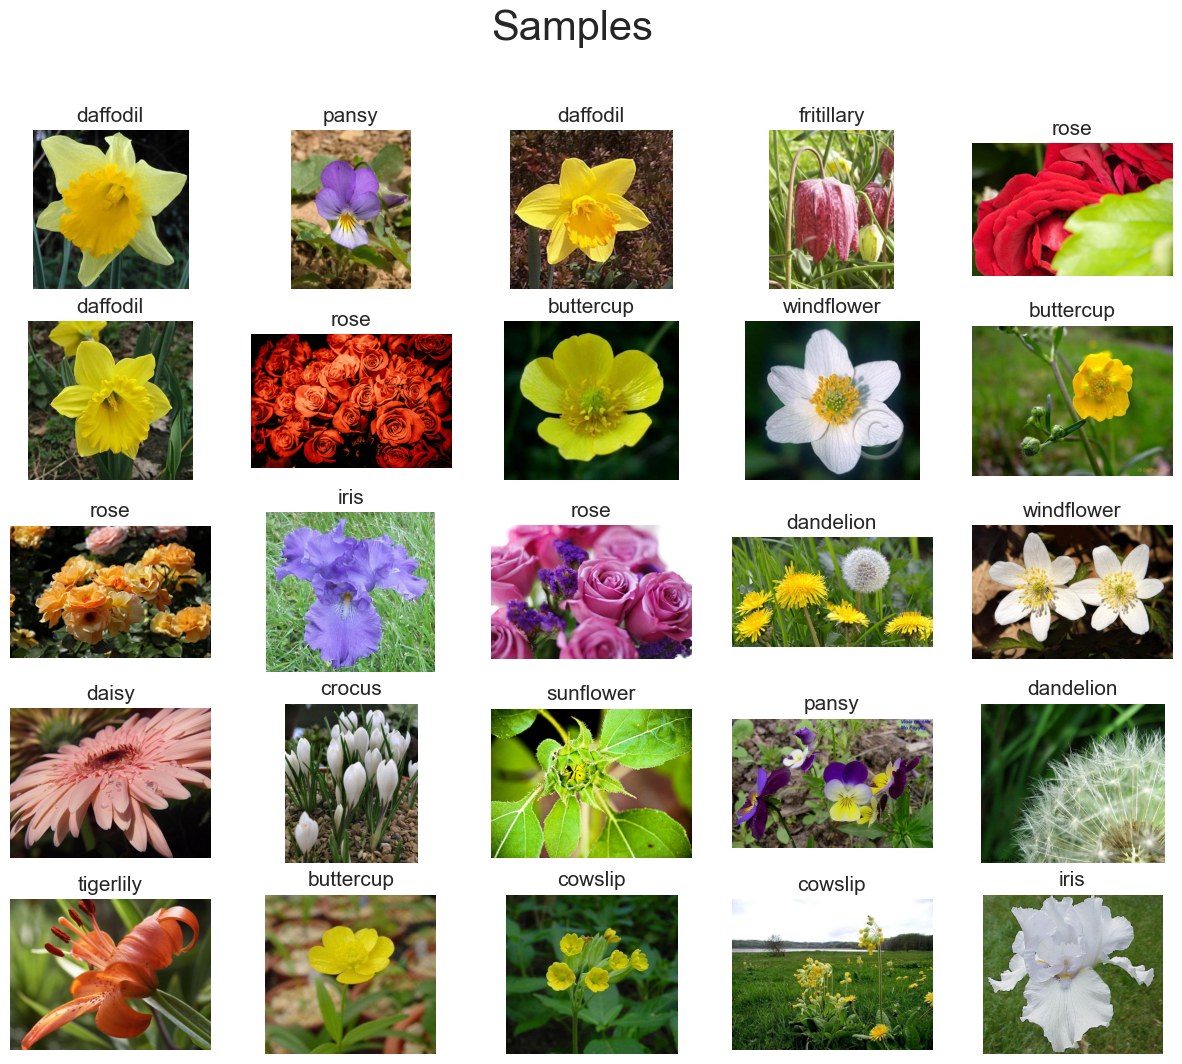

In [13]:
# Function for plotting samples
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15, 12))
    i = 0
    for row in range(5):
        for col in range(5):
            img = mpimg.imread(samples[i][0][0])
            ax[row][col].imshow(img)
            ax[row][col].axis('off')
            ax[row][col].set_title(samples[i][1], fontsize=15)
            i += 1


rand_samples = []
for _ in range(25):
    # 随机选取一个类别
    classes = random.choice(original.classes)
    # 随机从classes类中选取一个图片
    # 给sample()传入保存了类别中所有图片路径的列表，以及一个int参数表明从中选几个样本
    rand_samples.append([random.sample(
        [os.path.join(path + '/' + classes, filename) for filename in os.listdir(path + '/' + classes)], 1), classes])
# rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

## 下面是经过增强后的图片的样子

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


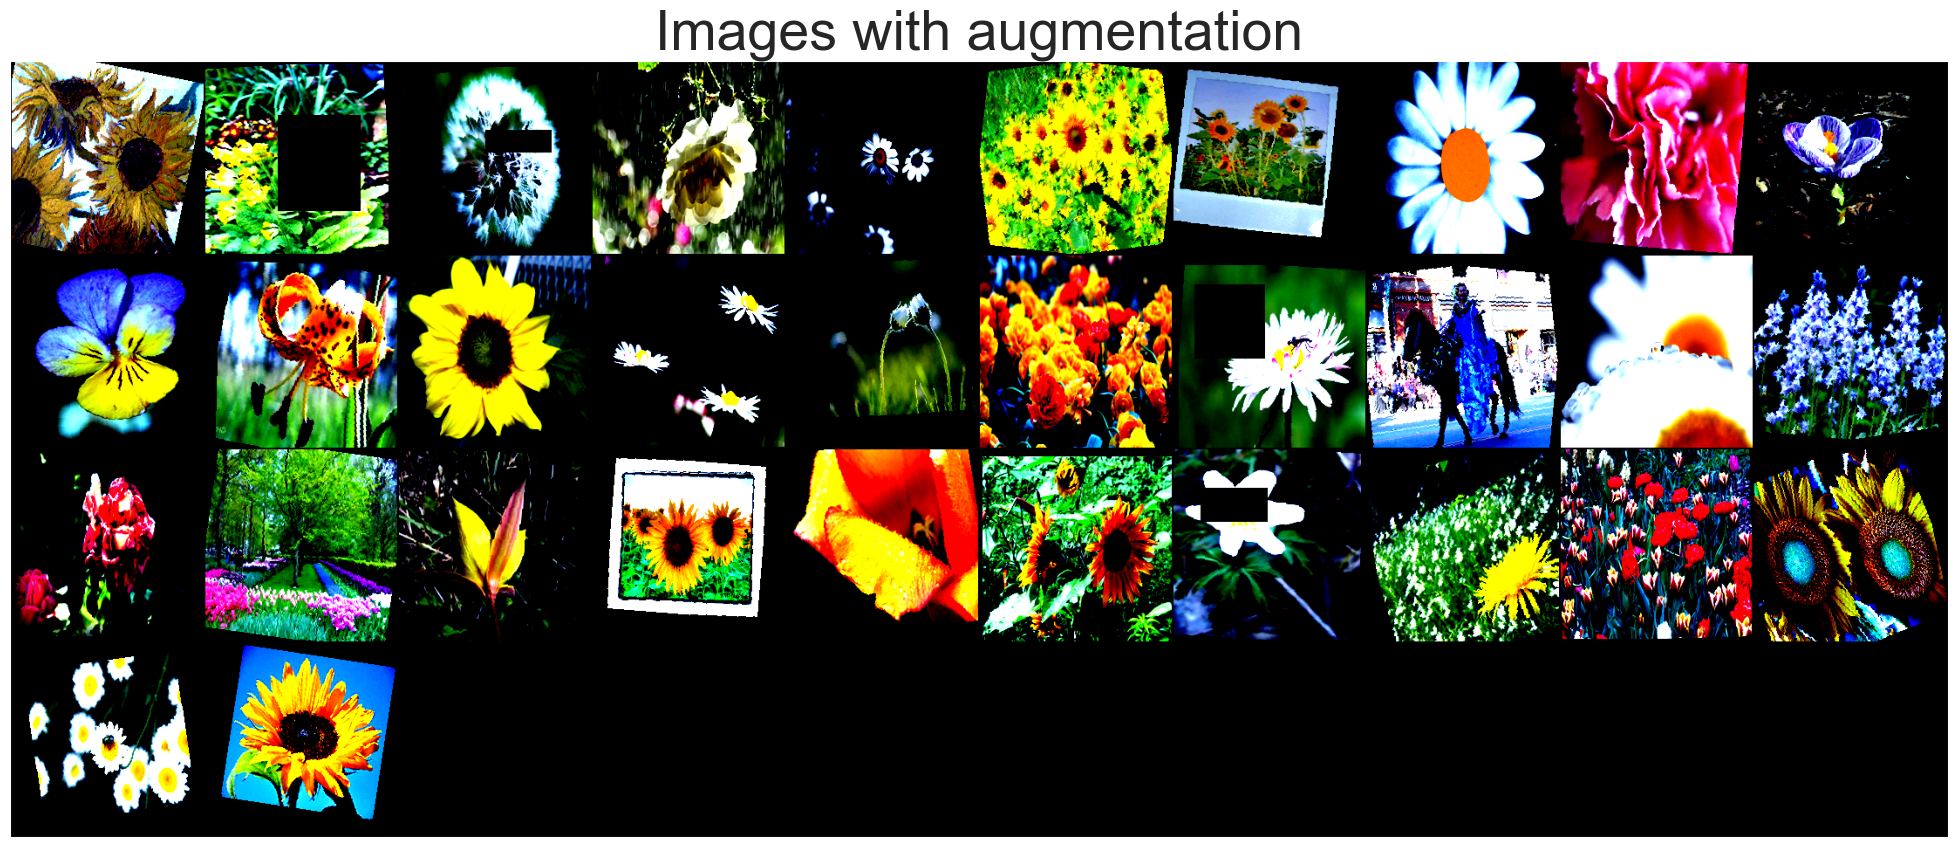

In [14]:
def show_batch(dl):
    """
    这个函数的作用是展示数据集里的图像
    :param dl: DataLoader
    :return: null
    """
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]);
        ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break


show_batch(loaders['train'])

## 开始训练模型并测试
**训练方法：** 使用了一个预处理模型的集合，在前十个循环中先只训练分类层，也就是冻结训练，然后再解冻训练，改变特征提取网络，这里因为不同类别的花朵数据集中的数量差异较大，导致部分网络模型解冻后训练反而正确率下降，损失值上升，后续优化的时候会尽量收集图片，将数据集中每种花的图片数量平衡

**这是一个定义准确率的函数，它的参数是模型的输出和真实的标签，它的返回值是一个张量，表示预测正确的比例，以及一个张量，表示预测的标签。这个函数可以用来评估模型的性能。最后一句话的意思是把预测的标签和真实的标签进行比较，如果相等就返回True，否则返回False，然后把这些布尔值相加，得到预测正确的个数，再除以总的个数，得到预测正确的比例。这个比例是一个数字，所以用.item()方法把它从张量中取出，然后用torch.tensor()方法把它转换成一个张量。最后，把这个张量和预测的标签一起返回。**

In [15]:
def accuracy(outputs, labels):
    """
    计算正确率的函数
    这是一个定义准确率的函数，它的参数是模型的输出和真实的标签，它的返回值是一个张量，表示预测正确的比例，以及一个张量，表示预测的标签。这个函数可以用来评估模型的性能。最后一句话的意思是把预测的标签和真实的标签进行比较，如果相等就返回True，否则返回False，然后把这些布尔值相加，得到预测正确的个数，再除以总的个数，得到预测正确的比例。这个比例是一个数字，所以用.item()方法把它从张量中取出，然后用torch.tensor()方法把它转换成一个张量。最后，把这个张量和预测的标签一起返回。
    :param outputs: 模型的输出数据
    :param labels: 花朵类别标签
    :return: 张量和预测的标签
    """

    # 返回每一行中最大值以及其索引，outputs就是输入数据，把最终输出结果中每一行的最大值取出其索引，preds就是标签值
    _, preds = torch.max(outputs, dim=1)  # “_”的意思是接收返回的第一个值，但是丢掉它，后面不会使用

    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

**下面是用来记录训练过程的，有助于后面可视化，以帮助我们评估和调整参数，比如训练过程中是否过拟合、欠拟合等**

In [16]:
# save the losses for further visualization
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}
lr = []

### 训练模型函数

In [17]:
def train(seed, epochs, model):
    """
    卷积神经网络训练函数，训练结构是：
    1. Classifier Training: 卷积神经网络中Classifier Training是指在卷积神经网络的最后一层，使用一个或多个全连接层（Dense Layer）来对输入的特征进行分类。全连接层将向量作为输入，而卷积层的输出为三维张量。因此，需要将三维张量展平为一维向量，然后使用激活函数（如softmax）来输出每个类别的概率。
    2. Network-wide Training: 卷积神经网络中Network-wide Training是指在整个网络上进行训练，而不是只在某一层或某一部分进行训练。这样可以使网络的每一层都能够学习到数据的特征，提高网络的性能和泛化能力。
    :param seed: 模型的代号，0-4分别是densenet121_0，densenet121_1，googlenet，resenet101，
    vgg19-bn
    :param epochs: 训练次数
    :param model: 传入的模型架构，比如VGG19、ResNet等
    :return: 训练好的模型
    """

    print('Creating a model {}...'.format(seed))

    # 将数据转移到GPU上，使用GPU训练
    model.to(device)

    # 创建计算交叉熵损失的类
    # 激活函数使用的可能是sigmoid函数
    criterion = nn.CrossEntropyLoss()

    # 搜索资料发现，使用Adam优化器而不用SGD的原因是Adam在开始时收敛比较快，方便快速验证和训练，而且原数据集不大，仅仅是5种花朵，4242张图片，故这里用Adam更合适
    # 如果模型是googlenet或resnet
    if seed == 2 or seed == 3:
        # model.fc.parameters()和model.classifier.parameters()是包含了所有需要优化的参数集，注意，这是冻结训练阶段，因此只有全连接层或者分类层的参数需要调整
        # betas是计算梯度以及梯度平方的运行平均值系数
        # eps是为了增加计算稳定性而添加到分母里的项
        # weight_decay是权重衰减
        # fc，全连接层
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
    # 模型densenet和vgg19模型类中参数定义用的是classifier，分类层
    else:
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    # 当patience个循环后模型训练效果不再变好的时候降低学习率，新的学习率lr=lr*factor，如果verbose为True，则每次学习率更新则输出更新信息，更新模式为max，表示dynamic_threshold=best*(1+threshold)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)

    # 当前时间，用于计算训练耗时
    since = time.time()

    # 将训练效果最好的模型通过深复制保存到best_model下来
    # state_dict()可返回一个保存了模型可学习参数的字典
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                # 如果是训练集，就用模型训练
                model.train()
            else:
                # 如果是验证集，就预测
                model.eval()

            # 每个循环的错误个数和正确个数
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # 初始化模型参数梯度为0
                optimizer.zero_grad()

                # 设置是否启用梯度计算，如果是训练阶段，则启用，如果是验证阶段，则停用以加快训练速度
                with torch.set_grad_enabled(phase == 'train'):
                    # 传入数据给模型，开始训练，获取训练输出结果，也就是属于每个类别的概率
                    outp = model(inputs)

                    # 取最大值，也就是最有可能是哪个类别
                    _, pred = torch.max(outp, 1)

                    # 计算一个batch损失值
                    loss = criterion(outp, labels)

                    # 如果是训练阶段
                    if phase == 'train':
                        # 反向传播，更新函数
                        loss.backward()

                        # 优化器更新参数
                        optimizer.step()
                #             lr.append(scheduler.get_lr())
                #             scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == 'train':
                acc = 100. * running_corrects.double() / dataset_sizes[phase]

                # 学习率更新器根据准确率更新学习率
                scheduler.step(acc)

            # 一个循环后，计算该次循环的错误率和正确率
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.to("cpu")

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch + 1, epochs))
            print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
            lr.append(scheduler._last_lr)

            if phase == 'val':
                print('Time: {}m {}s'.format((time.time() - since) // 60, (time.time() - since) % 60))
                print('==' * 31)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

                # 如果本次训练的模型参数在验证集上效果更好，则更新最优参数为当前参数
                best_model = copy.deepcopy(model.state_dict())
        #scheduler.step()
    time_elapsed = time.time() - since
    # 分类器训练完成，输出训练总用时
    print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('==' * 31)

    # 下面开始解冻阶段训练，
    # 加载最优参数的模型
    model.load_state_dict(best_model)

    for param in model.parameters():
        param.requires_grad = True

    # 注意，这里是解冻阶段，因此参数全部都要调，model.parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #             lr.append(scheduler.get_lr())
                #             scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == 'train':
                acc = 100. * running_corrects.double() / dataset_sizes[phase]
                scheduler.step(acc)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.to("cpu")
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch + 1, epochs))
            print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
            lr.append(scheduler._last_lr)

            if phase == 'val':
                print('Time: {}m {}s'.format((time.time() - since) // 60, (time.time() - since) % 60))
                print('==' * 31)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
        #scheduler.step()
    time_elapsed = time.time() - since
    print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('==' * 31)

    model.load_state_dict(best_model)
    return model

## 下载训练模型

In [18]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
    param.requires_grad = False

# 线性回归函数
# 用nn.Linear()设置网络中的全连接层，in和out都是二维张量，输出out可看作是分类个数
densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features,
                                     out_features=len(original.classes), bias=True)

In [19]:
densenet121_1 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_1.parameters():
    param.requires_grad = False

densenet121_1.classifier = nn.Linear(in_features=densenet121_1.classifier.in_features,
                                     out_features=len(original.classes), bias=True)

In [20]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
    param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=len(original.classes), bias=True)

In [21]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
    param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(original.classes), bias=True)

In [22]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
    param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, len(original.classes), bias=True)

### 开始训练

In [25]:
num_models = 5
epochs = 10

models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]

for seed in range(num_models):
    train(seed=seed, epochs=epochs, model=models[seed])

Creating a model 0...
Epoch: 1/10
train - loss:0.001200847476902919, accuracy0.9998214604534904
val - loss:0.032828615679209375, accuracy0.9890502261366342
Time: 2.0m 19.336307287216187s
Epoch: 2/10
train - loss:0.0003317439823299943, accuracy0.9999404868178301
val - loss:0.0323920274163747, accuracy0.9885741490121399
Time: 4.0m 29.289206504821777s
Epoch: 3/10
train - loss:0.0001412337429177549, accuracy1.0
val - loss:0.033103951813123984, accuracy0.9880980718876458
Time: 6.0m 39.63111662864685s
Epoch: 4/10
train - loss:9.271277318213361e-05, accuracy1.0
val - loss:0.03335643390344991, accuracy0.9880980718876458
Time: 8.0m 49.79808187484741s
Epoch: 5/10
train - loss:5.939291854887804e-05, accuracy1.0
val - loss:0.03351983756584141, accuracy0.988812187574387
Time: 11.0m 0.5526258945465088s
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 6/10
train - loss:4.295039428994284e-05, accuracy1.0
val - loss:0.033918550230673875, accuracy0.9890502261366342
Time: 13.0m 10.695

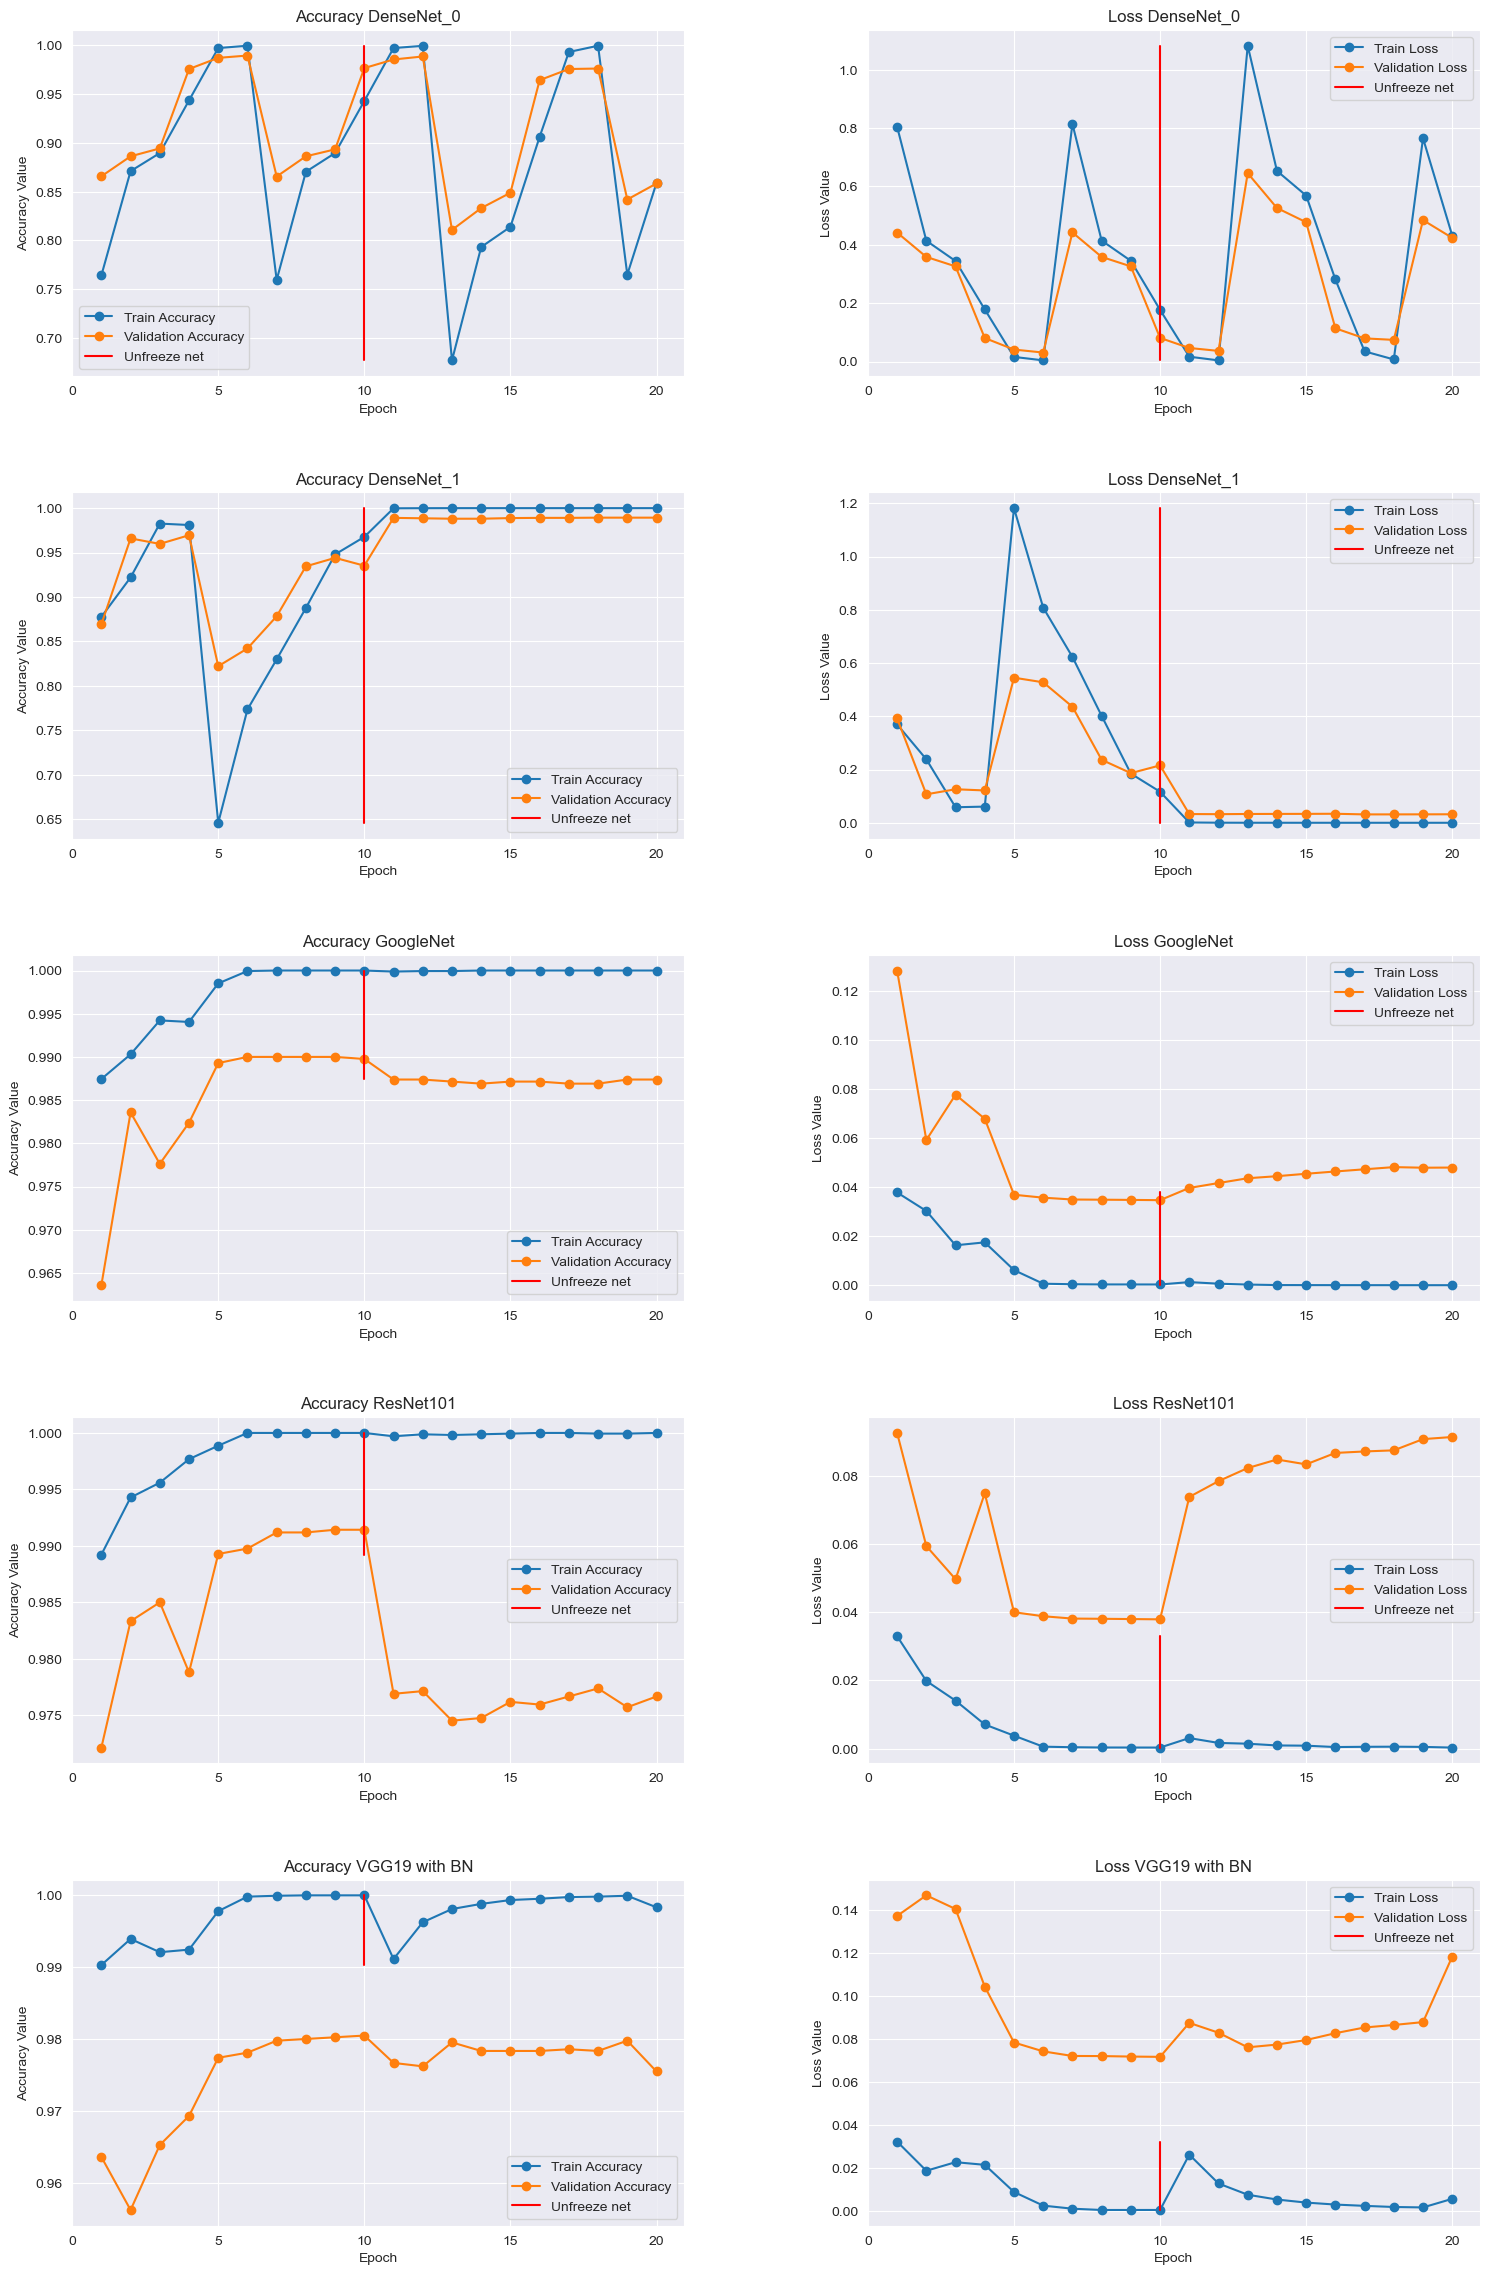

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
modelname = ['DenseNet_0', 'DenseNet_1', 'GoogleNet', 'ResNet101', 'VGG19 with BN']

i = 0

for row in range(5):
    # range()函数是左闭右开的
    epoch_list = list(range(1, epochs * 2 + 1))

    # 训练正确率变化曲线
    ax[row][0].plot(epoch_list, accuracies['train'][i:20 + i], '-o', label='Train Accuracy')
    # 验证正确率变化曲线
    ax[row][0].plot(epoch_list, accuracies['val'][i:20 + i], '-o', label='Validation Accuracy')
    # 解冻分割线
    ax[row][0].plot([epochs for x in range(20)],
                    # 生成一个指定范围内的均匀分布的序列化列表
                    np.linspace(min(accuracies['train'][i:20 + i]), max(accuracies['train'][i:20 + i]), 20),
                    color='r', label='Unfreeze net')
    ax[row][0].set_xticks(np.arange(0, epochs * 2 + 1, 5))
    ax[row][0].set_ylabel('Accuracy Value')
    ax[row][0].set_xlabel('Epoch')
    ax[row][0].set_title('Accuracy {}'.format(modelname[row]))
    ax[row][0].legend(loc="best")

    ax[row][1].plot(epoch_list, losses['train'][i:20 + i], '-o', label='Train Loss')
    ax[row][1].plot(epoch_list, losses['val'][i:20 + i], '-o', label='Validation Loss')
    ax[row][1].plot([epochs for x in range(20)],
                    np.linspace(min(losses['train'][i:20 + i]), max(losses['train'][i:20 + i]), 20),
                    color='r', label='Unfreeze net')
    ax[row][1].set_xticks(np.arange(0, epochs * 2 + 1, 5))
    ax[row][1].set_ylabel('Loss Value')
    ax[row][1].set_xlabel('Epoch')
    ax[row][1].set_title('Loss {}'.format(modelname[row]))
    ax[row][1].legend(loc="best")
    # 设置紧凑布局
    fig.tight_layout()
    fig.subplots_adjust(top=1.5, wspace=0.3)

    i += 20

## 测试

### 将5个模型集合到一起

In [27]:
class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble, self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList(models)

    def forward(self, x):
        # it is super simple. just forward num_ models and concat it.
        # 返回一个形状为[x.size(0),18]，里面的值全为0的tensor
        output = torch.zeros([x.size(0), len(original.classes)]).to(device)
        for model in self.models:
            output += model(x)
        return output

In [28]:
model = Ensemble(device)

model_file = open('./model.pkl', 'wb')
pickle.dump(model, model_file)
model_file.close()

In [29]:
# model = pickle.load(open("model.pkl", "rb"))

### 测试集正确率

In [30]:
def validation_step(batch):
    """
    验证阶段计算损失值和正确率
    :param batch: 一个批次数据
    :return: 一个字典，包含损失值，正确率，预测值和真实类别
    """
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out = model(images)

    # 用交叉熵函数计算输出和标签之间的损失
    loss = F.cross_entropy(out, labels)
    acc, preds = accuracy(out, labels)

    # 返回结果需要经过分离处理，禁用梯度计算
    return {'val_loss': loss.detach(), 'val_acc': acc.detach(),
            'preds': preds.detach(), 'labels': labels.detach()}

In [31]:
def test_prediction(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    # combine predictions
    batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
    # combine labels
    batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

    return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
            'test_preds': batch_preds, 'test_labels': batch_labels}

In [32]:
# 禁用梯度计算
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader]
    results = test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']

In [33]:
model.to(device)
preds, labels = test_predict(model, loaders['test'])

test_loss: 0.0236, test_acc: 0.9983


## 开始预测，随机选择一张图片进行预测

**下面的函数用来将经过归一化的图片还原回原始图片**

In [34]:
def norm_out(img):
    """
    将一张图像进行标准化、归一化的逆操作，即将图像的每个像素值乘以标准差，再加上平均值，从而恢复到原始的数值范围
    :param img: 一个三维的张量，表示一张图像，第一维是通道数，第二维是高度，第三维是宽度
    :return:一个三维的数组，表示一张图像，第一维是高度，第二维是宽度，第三维是通道数，每个元素的值在（0，1）之间
    """
    img = img.permute(1, 2, 0)
    mean = torch.FloatTensor([0.4124234616756439, 0.3674212694168091, 0.2578217089176178])
    std = torch.FloatTensor([0.3268945515155792, 0.29282665252685547, 0.29053378105163574])

    img = img * std + mean

    # 将img中的数据归一化到[0,1]范围内
    return np.clip(img, 0, 1)

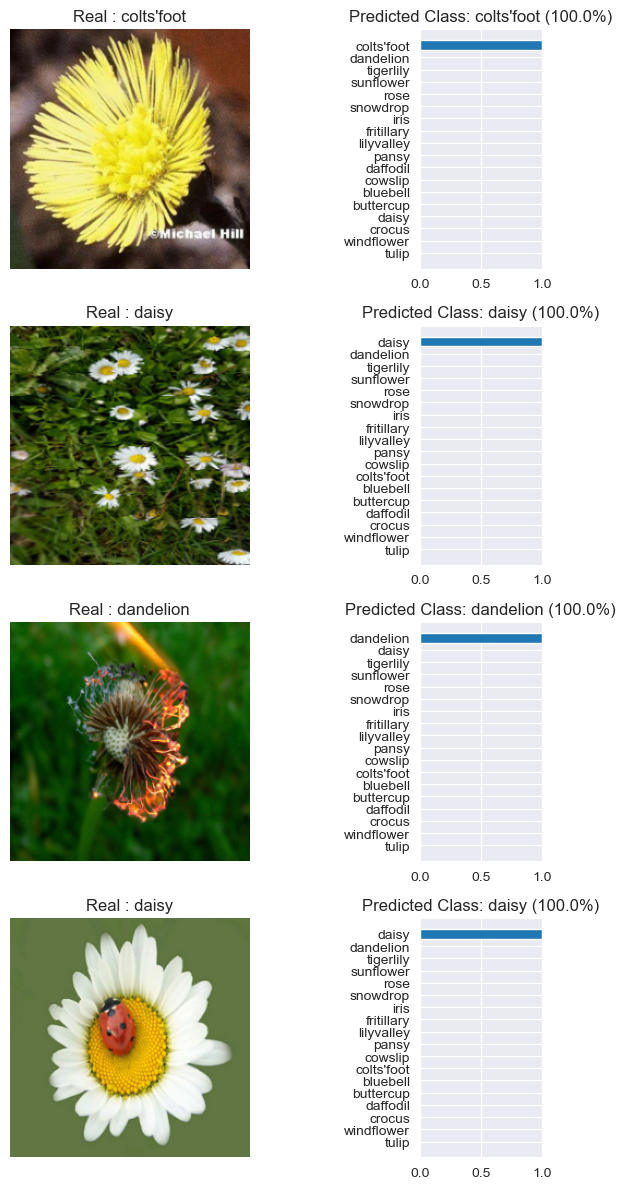

In [35]:
fig, ax = plt.subplots(figsize=(8, 12), ncols=2, nrows=4)

for row in range(4):
    i = np.random.randint(0, high=len(test))
    img, label = test[i]

    # 柔性最大值传输函数，将预测概率大的数值放大
    m = nn.Softmax(dim=1)
    # 计算每个类别的百分比
    # unsqueeze表示升维，0表示在张量最外层加多一个中括号
    percent = m(model(img.to(device).unsqueeze(0)))
    # 类别预测概率
    predmax3percent = torch.sort(percent[0])[0]
    # 类别标签列表
    predmax3inds = torch.sort(percent[0])[1]
    classes = np.array(
        [original.classes[predmax3inds[-18]], original.classes[predmax3inds[-17]], original.classes[predmax3inds[-16]],
         original.classes[predmax3inds[-15]], original.classes[predmax3inds[-14]], original.classes[predmax3inds[-13]],
         original.classes[predmax3inds[-12]], original.classes[predmax3inds[-11]], original.classes[predmax3inds[-10]],
         original.classes[predmax3inds[-9]], original.classes[predmax3inds[-8]], original.classes[predmax3inds[-7]],
         original.classes[predmax3inds[-6]], original.classes[predmax3inds[-5]], original.classes[predmax3inds[-4]],
         original.classes[predmax3inds[-3]],
         original.classes[predmax3inds[-2]], original.classes[predmax3inds[-1]]])
    class_name = original.classes

    ax[row][0].imshow(norm_out(img))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, predmax3percent.detach().cpu().numpy())
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_title('Predicted Class: {} ({}%)'.format(original.classes[predmax3inds[-1]],
                                                            round((predmax3percent[-1] * 100).item(), 2)))
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()

In [36]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=original.classes)
report_df = pd.DataFrame(report).transpose()

In [37]:
pd.set_option("display.max_rows", None)
report_df.head(134)

precision    recall  f1-score      support
bluebell       1.000000  1.000000  1.000000    22.000000
buttercup      1.000000  1.000000  1.000000    21.000000
colts'foot     1.000000  1.000000  1.000000    17.000000
cowslip        1.000000  1.000000  1.000000    25.000000
crocus         1.000000  1.000000  1.000000    21.000000
daffodil       1.000000  1.000000  1.000000    30.000000
daisy          1.000000  1.000000  1.000000   258.000000
dandelion      1.000000  1.000000  1.000000   342.000000
fritillary     1.000000  1.000000  1.000000    26.000000
iris           1.000000  1.000000  1.000000    22.000000
lilyvalley     1.000000  1.000000  1.000000    23.000000
pansy          1.000000  1.000000  1.000000    26.000000
rose           0.995918  0.995918  0.995918   245.000000
snowdrop       1.000000  1.000000  1.000000    21.000000
sunflower      1.000000  0.995633  0.997812   229.000000
tigerlily      1.000000  1.000000  1.000000    24.000000
tulip          0.993958  0.996970  0.995461   330.000000
windflower     1.000000  1.000000  1.000000    22.000000
accuracy       0.998239  0.998239  0.998239     0.998239
macro avg      0.999438  0.999362  0.999400  1704.000000
weighted avg   0.998243  0.998239  0.998240  1704.000000

<Figure size 4000x2000 with 0 Axes>

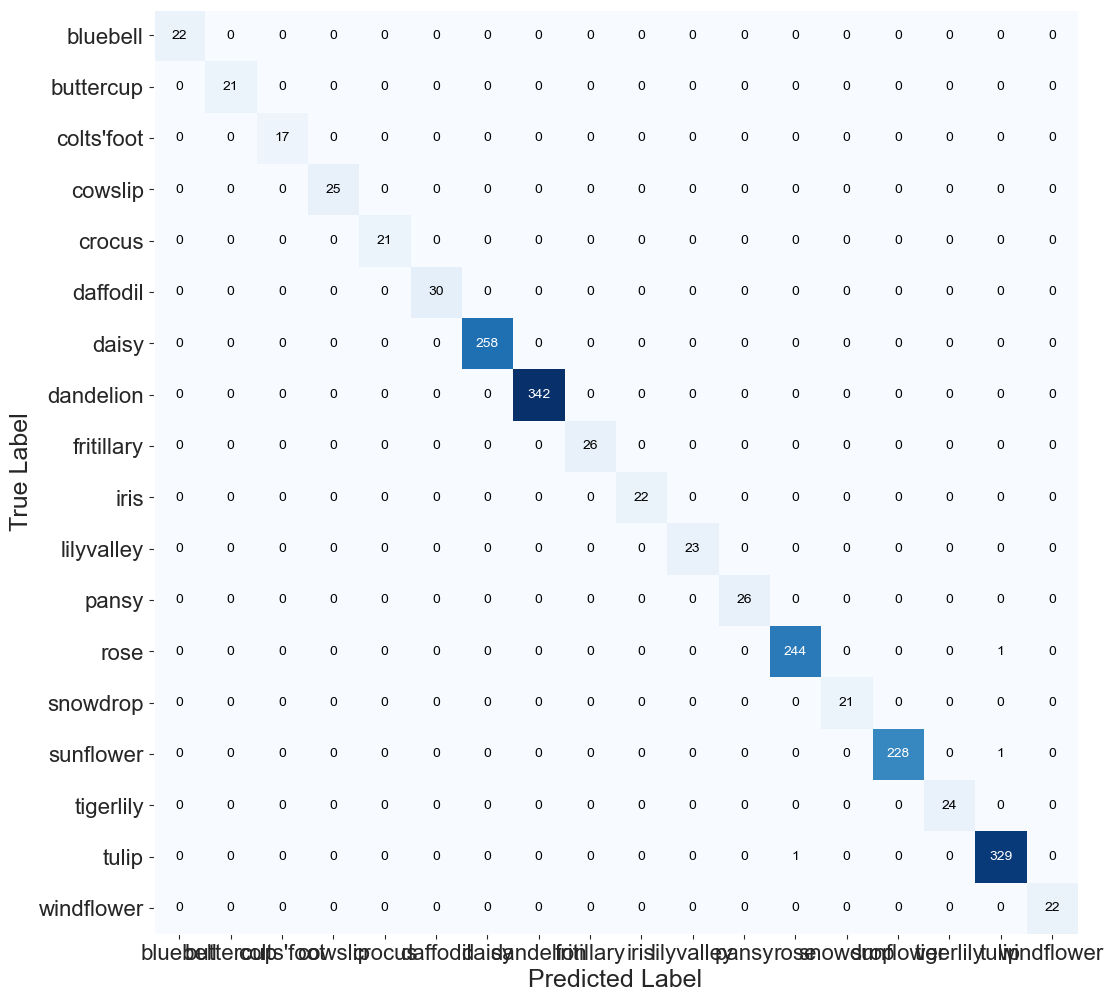

In [38]:
# Plot confusion matrix
# 绘制混淆矩阵
cm = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 12), cmap=plt.cm.Blues)
plt.xticks(range(len(original.classes)), original.classes, fontsize=16)
plt.yticks(range(len(original.classes)), original.classes, fontsize=16)
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()